In [23]:
import time
import numpy as np
import argparse
import os

from astropy.time import Time   # Astropy 4.1rc1 is used

from orbdet.utils.utils import *
from orbdet.utils.utils_aux import *
from orbdet.utils.utils_vis import *

%matplotlib inline

np.random.seed(100)
np.set_printoptions(precision=2)

x_0, t_sec, x_sat_orbdyn_stm, x_obs_multiple, _ = get_example_scenario(id=3, frame='teme')
r, rr = range_range_rate(x_sat_orbdyn_stm, x_obs_multiple)
tof = r / C

print(r.shape)
print(tof.shape)

tdoa = np.copy(tof)

for i in range(r.shape[0]-1):
    tdoa[i,:] = tof[0,:] - tof[i,:]


(4, 240)
(4, 240)


In [24]:
print(tof.shape)
print(x_obs_multiple.shape)

(4, 240)
(6, 240, 4)


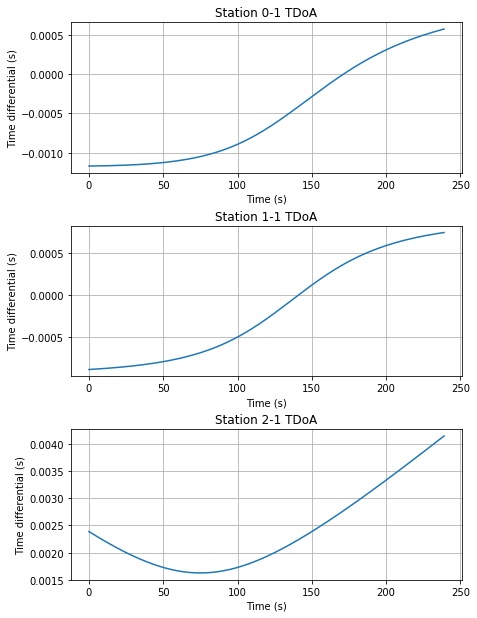

In [25]:
n_obs = x_obs_multiple.shape[2]

fig = plt.figure(figsize=(7,14))

for i in range(n_obs-1):
    ax1 = fig.add_subplot(n_obs, 1, i+1)
    ax1.plot(t_sec, tdoa[i+1,:])
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Time differential (s)')
    ax1.grid(':')
    ax1.title.set_text(f"Station {i}-1 TDoA")

fig.subplots_adjust(hspace=0.35)
